<h2 align="center" style="color:purple"> Bank Credit Card Project</h2>

In [447]:
import pandas as pd
import mysql.connector
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as st

In [311]:
conn = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database = "e_master_card"
)

### As of now we have 3 tables in the databease - e_master_card. They are:
1. <span style="color: green;">credit_profiles</span>
2. <span style="color: red;">customers</span>
3. <span style="color: blue;">transactions</span>

Let's import data each tables from the database using **read_sql()**

In [312]:
#importing data from customers table
df_customers = pd.read_sql("SELECT * from customers",conn)
df_customers.head()

/var/folders/md/3r5147mj0951vm3v86b8vymmjmg0m4/T/ipykernel_3266/1338170051.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql("SELECT * from customers",conn)


,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563,Married
4,5,Advait Malik,Male,48,City,Consultant,39406,Married


In [313]:
#importing data from transactions table
df_transactions = pd.read_sql("SELECT * from transactions",conn)
df_transactions.head()

/var/folders/md/3r5147mj0951vm3v86b8vymmjmg0m4/T/ipykernel_3266/1757468563.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transactions = pd.read_sql("SELECT * from transactions",conn)


,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [314]:
#importing data from credit_profiles table
df_credit_profiles = pd.read_sql("SELECT * from credit_profiles",conn)
df_credit_profiles.head()

/var/folders/md/3r5147mj0951vm3v86b8vymmjmg0m4/T/ipykernel_3266/2201032975.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_credit_profiles = pd.read_sql("SELECT * from credit_profiles",conn)


,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [315]:
#closing the connection
conn.close()

## <span style="color: red;"> **Let's have some EDA on Customer DF** </span>

In [316]:
#Running Describe to understand the df_customers
df_customers.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,132439.799000
std,288.819436,15.666155,113706.313793
min,1.000000,1.000000,0.000000
25%,250.750000,26.000000,42229.750000
50%,500.500000,32.000000,107275.000000
75%,750.250000,46.000000,189687.500000
max,1000.000000,135.000000,449346.000000


In [317]:
#Check of Null Values
df_customers.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

##### From above 2, decribe and **isnull()** check we couldn't find any null values but the minimum value in annual_income column is 0.00 which is not possible. So let's handle that first. This can also be handled while checking for outliers. Though handling here.

#### <span style="color: green;"> **Handling Null values and Outliers for Annual Income** </span>

In [318]:
#Retriving rows with the value 0.00 in annual income.
print(f"Rows with Annual income 0.0 :- {(df_customers["annual_income"] == 0).sum()}")
df_customers[df_customers["annual_income"]==0.00].head()

Rows with Annual income 0.0 :- 50


,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,0,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,0,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,0,Married
102,103,Aarav Shah,Male,32,City,Data Scientist,0,Married
155,156,Kiaan Saxena,Male,24,City,Fullstack Developer,0,Married


##### So this values can be ignored and removed. But as the Dataframe have only <span style="color: orange;">1000 rows</span> and removing this would be 5% rows removed. Let's handle this. This can be handled with mean and median. In this case mean wont give a fruitful result as we haven't removed the outliers. So will go with median. 

##### While considering to take a median for whole column, that might not be good as each occupation people would have particular income rate. So let's consider them and group it with respect to each occupation.

In [319]:
#Finding occupation wise median
occupation_wise_median = df_customers.groupby("occupation")["annual_income"].median()
occupation_wise_median

occupation
Accountant              65265.0
Artist                  44915.0
Business Owner         254881.0
Consultant              51175.0
Data Scientist         127889.0
Freelancer              45189.5
Fullstack Developer     74457.0
Name: annual_income, dtype: float64

So now the above median per occupation must be replaced in place of 0.00 in annual_income column. May this can be handled by writing a function for it.

In [320]:
#This functions receives each row from df_customers and returns the required value where annual income value is 0
def get_median_val_occupation(row):
    if row["annual_income"] == 0:
        return occupation_wise_median[row["occupation"]]
    else:
        return row["annual_income"]

In [321]:
#get_median_val_occupation() method applied for each rows
df_customers["annual_income"] = df_customers.apply(get_median_val_occupation, axis=1)

In [322]:
#After applying let's check if any possible 0 again
print(f"Rows with Annual income 0.0 :- {(df_customers["annual_income"] == 0).sum()}")
df_customers[df_customers["annual_income"]==0.00]

Rows with Annual income 0.0 :- 0


,cust_id,name,gender,age,location,occupation,annual_income,marital_status


So now 0.00 in the annual_income column have been handled.

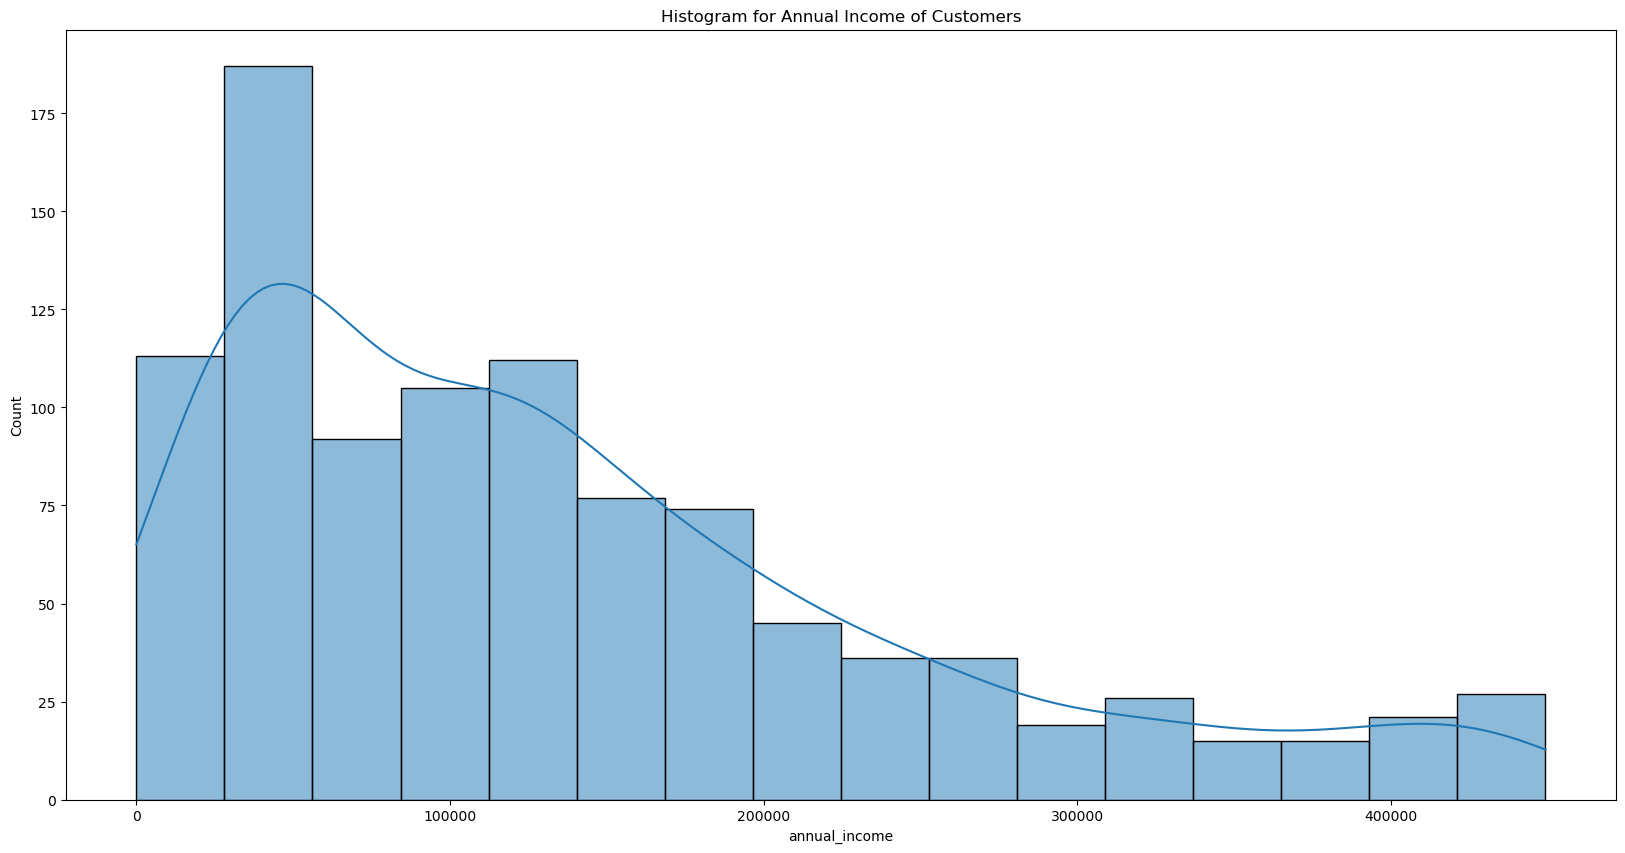

In [323]:
#Let's plot a distribution for annual income using histogram
plt.figure(figsize =(20,10))
sns.histplot(df_customers["annual_income"], kde=True )
plt.title("Histogram for Annual Income of Customers")
plt.show()

#### From the above Historgram distribution we can find that the annual income is <span style="color: orange;">**Right skewed**</span>, i.e More people are found with less income category while High income people are less in count.

In [324]:
df_customers.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138634.437500
std,288.819436,15.666155,110961.396638
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48229.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


---So after handling values 0, while checking with **describe()** we could still find annual_income minimum value in single digit 2.0, which is not a possible value. Here let's take 100 as minimum value and anything less than 100 can be considered as outlier. This is because if we take 3*STD method it goes to negative value so, taking the minimum value a 100.---

In [325]:
#Annual income less than 100
print(f"Count of customers with Income less than 100:- {(df_customers["annual_income"]<100).sum()}")
df_customers[df_customers["annual_income"]<100]

Count of customers with Income less than 100:- 10


,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


In [326]:
#As done for the 0.0 values same median method can be used to remove outliers less than 100. So let's try it using iterro

for index, row in df_customers.iterrows():
    if row["annual_income"]<100:
        df_customers.at[index,"annual_income"] = occupation_wise_median[row["occupation"]]

In [327]:
print(f"Count of customers with Income less than 100:- {(df_customers["annual_income"]<100).sum()}")
df_customers[df_customers["annual_income"]<100]

Count of customers with Income less than 100:- 0


,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [328]:
#To test with the insex from above data, can be checked with iloc
df_customers.loc[[31,316,333]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,254881.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,51175.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,127889.0,Married


--- So from the above we can confirm that the values are changed. --- Now let's visualize this data with respect to occupation

In [329]:
#Finding occupation wise average
occupation_wise_average = df_customers.groupby("occupation")["annual_income"].mean().sort_values()
occupation_wise_average

occupation
Artist                  45239.842105
Consultant              59927.257732
Accountant              64123.562500
Freelancer              76293.089912
Fullstack Developer     78618.385135
Data Scientist         136208.603261
Business Owner         268119.833910
Name: annual_income, dtype: float64

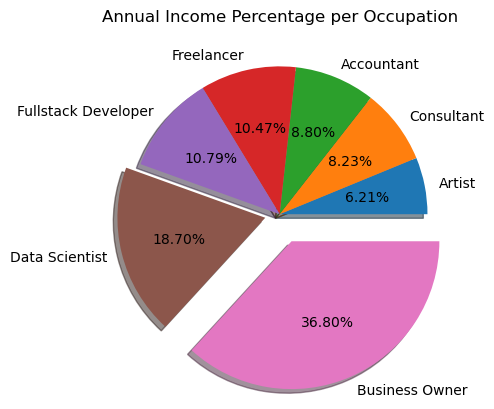

In [330]:
plt.pie(occupation_wise_average, labels=occupation_wise_average.index, autopct="%1.2f%%",explode = [0,0,0,0,0,0.1,0.2], shadow=True)
plt.title("Annual Income Percentage per Occupation")
plt.show()

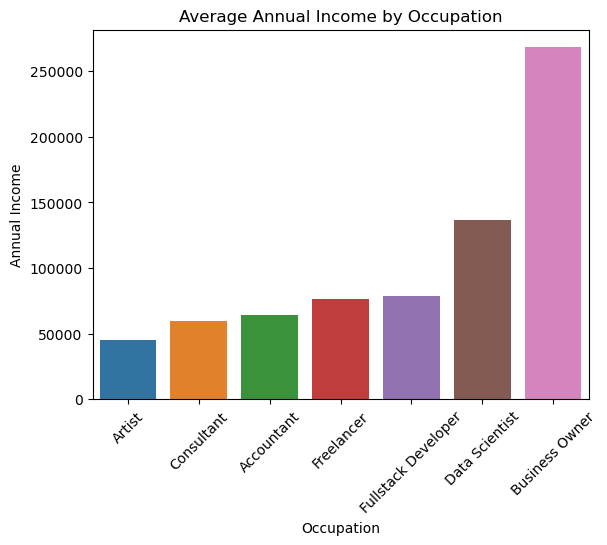

In [331]:
sns.barplot(x=occupation_wise_average.index, y=occupation_wise_average.values,  hue=occupation_wise_average.index,palette= "tab10")
plt.xticks(rotation=45)
plt.xlabel("Occupation")
plt.ylabel("Annual Income")
plt.title("Average Annual Income by Occupation")
plt.show()

#### Let's visualize annual income w.r.t other categorical columns <span style="color: orange;">**(gender, location, marital status)**</span>

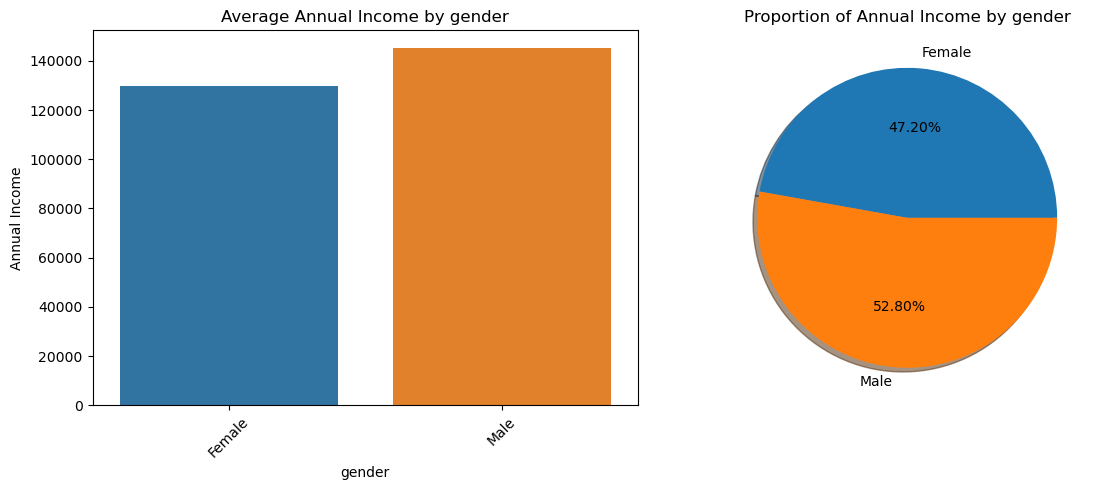

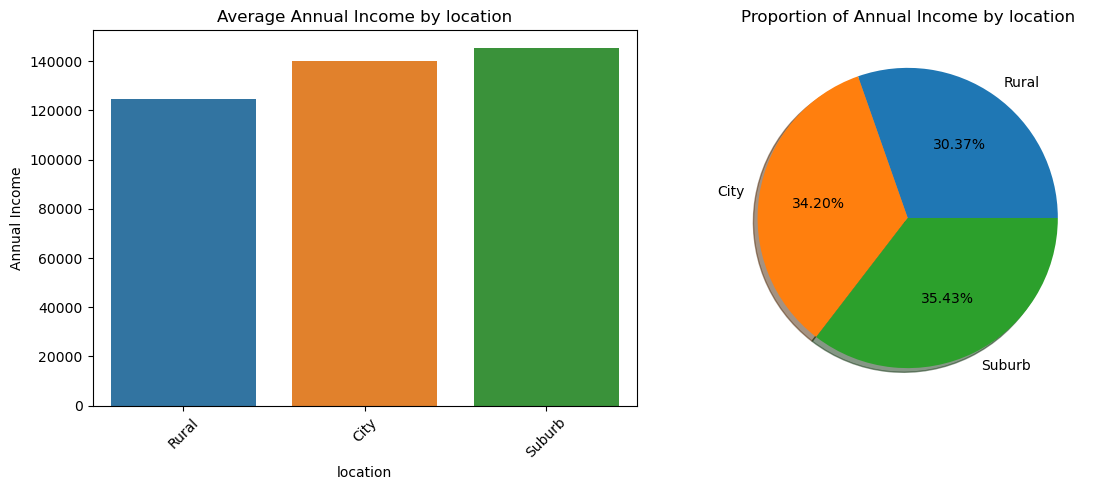

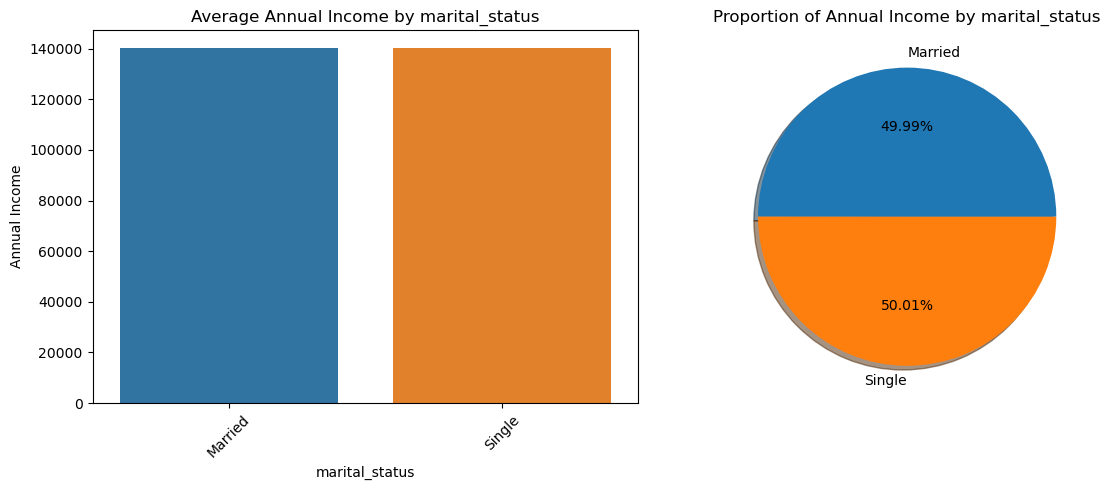

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

other_categorical_cols = ["gender", "location", "marital_status"]

for cols in other_categorical_cols:
    # Calculate average annual income per group
    avg_per_group = df_customers.groupby(cols)["annual_income"].mean().sort_values()

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar plot on the first subplot
    sns.barplot(ax=axes[0], x=avg_per_group.index, y=avg_per_group.values,  hue=avg_per_group.index, palette="tab10")
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[0].set_xlabel(cols)
    axes[0].set_ylabel("Annual Income")
    axes[0].set_title(f"Average Annual Income by {cols}")

    # Pie chart on the second subplot
    axes[1].pie(avg_per_group, labels=avg_per_group.index, autopct="%1.2f%%", shadow=True)
    axes[1].set_title(f"Proportion of Annual Income by {cols}")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

##### **From the above Visualiztion we are able to understand the below points**
<span style="color: green;">Annual Income by Occupation:</span>
1. Business Owners have more income around 250000$ - which is above 36% followed by
2. Data Scientists - who only earn 18% half of business owner and list continues as
3. Fullstack developer
4. Freelancer
5. Accountant
6. Consultant
7. Artist

<span style="color: red;">Annual Income by Gender:</span>
* Male's annual income is more than that of Female's annual income with 52.80% and 47.20% respectively

<span style="color: blue;">Annual Income by Location:</span>
All three locations have only little variation comparitively
1. Subhurb - 35.43%
2. City - 34.20%
3. Rural - 30.37%

<span style="color: Orange;">Annual Income by Marital Status:</span>
* W.r.t marital status we could only find slight variance in percentage with 50.01% and 49.99 for single's and married one's respectively

#### <span style="color: green;"> **Handling Null values and Outliers for Age** </span>

In [333]:
df_customers.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140137.395500
std,288.819436,15.666155,110450.464107
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


##### From the above describe we could find the minimum and maximum value of age 1 and 135 respectively, which is not possible. Any values below 15 and above 80 are considered to be outlier as above for annual income here too 3*STD gives negative values.

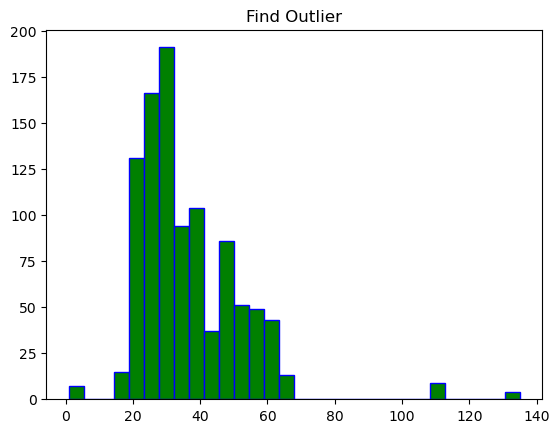

In [334]:
plt.hist(df_customers["age"],bins=30, color="green", edgecolor="blue")
plt.title("Find Outlier")
plt.show()

In [335]:
#Checking for outliers
print(f"Outlier Count of age:- {((df_customers["age"]<15) | (df_customers["age"]>80)).sum()}")
df_customers[(df_customers["age"]<15) | (df_customers["age"]>80)].head()

Outlier Count of age:- 20


,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married


In [336]:
#Here let's handle the outlier with mode w.r.t occupation
print(f"Most cutomers age:- {df_customers["age"].mode()[0]}")
occupation_wise_mode = df_customers.groupby("occupation")["age"].apply(lambda x: x.mode().iloc[0])
occupation_wise_mode

Most cutomers age:- 29


occupation
Accountant             26
Artist                 26
Business Owner         55
Consultant             47
Data Scientist         29
Freelancer             21
Fullstack Developer    29
Name: age, dtype: int64

In [337]:
df_customers["age"] = df_customers.apply(
    lambda row: occupation_wise_mode[row["occupation"]] 
    if (row.age < 18 or row.age > 80) and (row["occupation"] in occupation_wise_mode.index)
    else row.age,
    axis=1
)

In [338]:
#Checking for outliers
print(f"Outlier Count of age:- {((df_customers["age"]<15) | (df_customers["age"]>80)).sum()}")
df_customers[(df_customers["age"]<15) | (df_customers["age"]>80)].head()

Outlier Count of age:- 0


,cust_id,name,gender,age,location,occupation,annual_income,marital_status


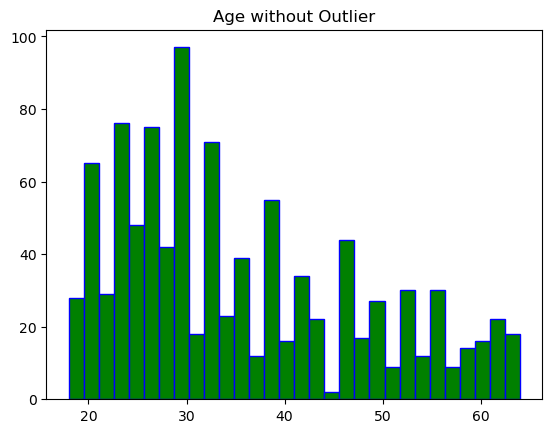

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,35.529000,140137.395500
std,288.819436,12.326114,110450.464107
min,1.000000,18.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,44.250000,195514.250000
max,1000.000000,64.000000,449346.000000


In [339]:
plt.hist(df_customers["age"],bins=30, color="green", edgecolor="blue")
plt.title("Age without Outlier")
plt.show()

df_customers.describe()

##### **From the above Visualiztion we are able to understand the below points**
<span style="color: green;">The outlier of age have been removed and the minimum and maximum values are 18 and 64 respectively</span>

##### **Now according to requirements the visualisation is to be done with a pie chart with age groups as <span style="color: red;">18-25, 26-47, 48-65</span>** For now we have age and not age group. Age group can be added using **apply(), lambda or iterrows()** as we have done previously for other columns. But here when researched online got another method known as **pd.cut()** to do it in single line. Let's try that.

In [340]:
#For this first bin edges and labels are to be defined
bin_edges = [18,25,48,65]
bin_labels =["18-25","26-48","49-65"]

#Now pd.cut() can be used to create new column
df_customers["age_group"] = pd.cut(df_customers["age"], bins=bin_edges, labels=bin_labels)
df_customers.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married,26-48


In [341]:
age_grp_count = df_customers["age_group"].value_counts()
age_grp_count

age_group
26-48    567
18-25    231
49-65    187
Name: count, dtype: int64

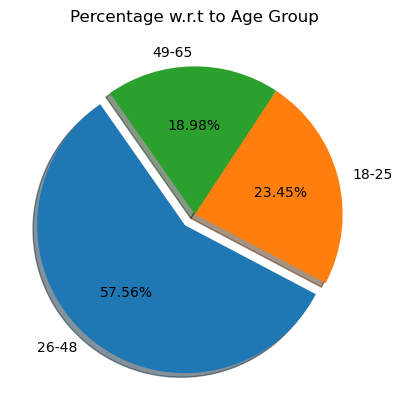

In [342]:
plt.pie(age_grp_count, labels=age_grp_count.index, autopct="%1.2f%%", explode = [0.1,0.0,0.0], shadow=True, startangle=125)
plt.title("Percentage w.r.t to Age Group")
plt.show()

##### **From the above Pie Chart we are able to understand that w.r.t age group**
1. 26-48 age group people are the most customers with more than half of the customers almost <span style="color: green;">57.56%</span>, followed by
2. 18-25 age group with <span style="color: green;">23.45%</span>
3. 49-65 age group with <span style="color: green;">18.98%</span>

##### Let's visualize with <span style="color: blue;">Stacked Bar Graph</span> the **Distribution w.r.t Location and Gender**

In [343]:
#Use groupby() with 2 columns with size() method to group and unstck() method to convert Series to dataframe(Researched online)
cust_loc_gen = df_customers.groupby(["location","gender"]).size().unstack()
cust_loc_gen

gender,Female,Male
location,,
City,226,457
Rural,26,59
Suburb,74,158


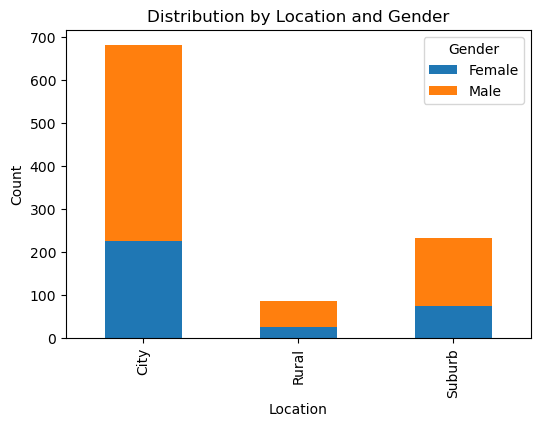

In [344]:
cust_loc_gen.plot(kind = "bar", stacked= True, figsize=(6,4))
plt.title("Distribution by Location and Gender")
plt.legend(title="Gender")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

## <span style="color: red;"> **Let's have some EDA on Credit Profile DF** </span>

In [345]:
df_credit_profiles.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [346]:
df_credit_profiles.shape

(1004, 6)

##### While checking the number of rows there are 1004 rows while customers df had only 1000 rows. So here there might be unwanted rows or duplicated rows. So let's check for duplicated rows.

In [347]:
#To get the duplicated values w.r.t "cust_id"
df_credit_profiles[df_credit_profiles["cust_id"].duplicated(keep= False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


##### From above retrieved rows we can understand the first row have NaN value but the second row have correct values. So we have to the second row.

In [348]:
#Remove duplicates using drop_duplicate()
df_clean_credprof= df_credit_profiles.drop_duplicates(subset="cust_id",keep="last")
df_clean_credprof.shape

(1000, 6)

##### The duplicates have been removed and let's have a null check for the each column in the new df **df_clean_credprof**

#### <span style="color: green;"> **Handling Null values and Outliers for Age** </span>

In [349]:
df_clean_credprof.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

In [350]:
#Printing Null rowns with null valuses in credit_limit column
df_clean_credprof[df_clean_credprof["credit_limit"].isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


##### Let's check how values are distributed in credit limit column. While checking with **ChatGPT** considering it as **Business manager**, it give suggestion to check the distribution and find if it's in slab structure and to check relation between credit score and credit limit and handle accordinly 

In [351]:
df_clean_credprof["credit_limit"].value_counts()

credit_limit
500.0      229
60000.0    186
40000.0    137
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

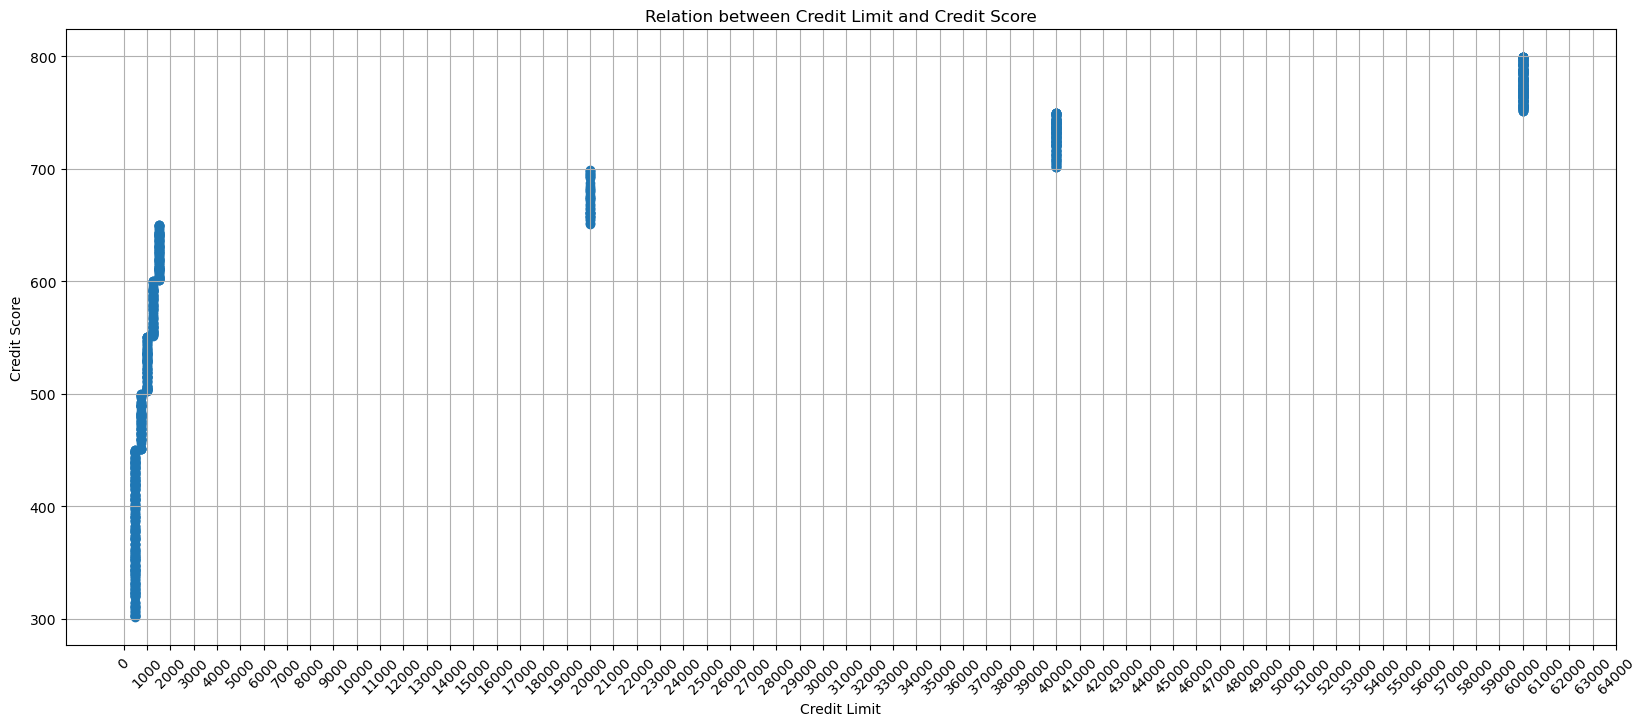

In [352]:
#Plotting Scatter plot with Credit limit and credit_score to find any relation between both variables
plt.figure(figsize =(20,8))
plt.scatter(df_clean_credprof["credit_limit"],df_clean_credprof["credit_score"])
plt.title("Relation between Credit Limit and Credit Score")
plt.xlabel("Credit Limit")
plt.ylabel("Credit Score")

plt.xticks(range(0,65000,1000),rotation=45)
plt.grid(True)
plt.show()

In [353]:
#From above graph we could find relation between both, so with that visualized relation let's create a credit score range 
bin_ranges = [start for start in range(300, 801, 50) if start not in (350, 400)] 
bin_labels = [f"{bin_ranges[0]}-449"] + [f"{start}-{start + 49}" for start in bin_ranges[1:]if start + 49 < 800]
(bin_ranges, bin_labels)

([300, 450, 500, 550, 600, 650, 700, 750, 800],
 ['300-449',
  '450-499',
  '500-549',
  '550-599',
  '600-649',
  '650-699',
  '700-749',
  '750-799'])

In [354]:
#Created credit score range column to add the range of value.
df_clean_credprof.loc[:, "cred_score_range"] = pd.cut(df_clean_credprof["credit_score"], bins=bin_ranges, labels=bin_labels)
df_clean_credprof.head()

/var/folders/md/3r5147mj0951vm3v86b8vymmjmg0m4/T/ipykernel_3266/3347997174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_credprof.loc[:, "cred_score_range"] = pd.cut(df_clean_credprof["credit_score"], bins=bin_ranges, labels=bin_labels)


,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


###### From the credit range, credit score and credit limit variables we are able to find almost each credit score in credit range have same credit limit. So taking mode would be a correct approach to handle the null values

In [355]:
mode_df = df_clean_credprof.groupby("cred_score_range", observed=True)["credit_limit"].agg(
    lambda x: x.mode(dropna=True).iloc[0] 
    if not x.mode(dropna=True).empty else None
).reset_index()

mode_df.head()

,cred_score_range,credit_limit
0,300-449,500.0
1,450-499,750.0
2,500-549,1000.0
3,550-599,1250.0
4,600-649,1500.0


In [356]:
df_clean_credprof[df_clean_credprof["credit_limit"].isnull()].sample(5)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range
399,400,754,0.884299,32031.0,2.0,NaN,750-799
167,168,737,0.489797,12421.0,2.0,NaN,700-749
617,615,776,0.278907,14937.0,0.0,NaN,750-799
414,415,646,0.503281,533.0,3.0,NaN,600-649
912,909,479,0.487555,320.0,3.0,NaN,450-499


In [357]:
#Mergeing main df and mode df to to new df while keeping new and ol credit_limit columns
df_cred_prof = pd.merge(df_clean_credprof, mode_df, on ="cred_score_range",
                        suffixes=("","_mode"))

In [358]:
df_cred_prof[df_cred_prof["credit_limit"].isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range,credit_limit_mode
430,431,610,0.741063,628.0,4.0,NaN,600-649,1500.0
167,168,737,0.489797,12421.0,2.0,NaN,700-749,40000.0
10,11,679,0.557450,9187.0,2.0,NaN,650-699,20000.0


In [359]:
#Filling the null values in credit limit with in new credit_limit_mode column
df_cred_prof["credit_limit"] = df_cred_prof["credit_limit"].fillna(df_cred_prof["credit_limit_mode"])

In [360]:
#just null check to find no null values.
df_cred_prof.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
cred_score_range                  0
credit_limit_mode                 0
dtype: int64

In [361]:
df_cred_prof.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [362]:
#Let's describe() once again 
df_cred_prof.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,500.323323,589.471471,0.498663,9692.948949,1.955956,19752.752753,19752.752753
std,288.910029,152.085696,0.233079,25266.811373,1.414944,24722.506641,24722.506641
min,1.000000,301.000000,0.103761,33.000000,0.000000,500.000000,500.000000
25%,250.500000,460.000000,0.293785,221.000000,1.000000,750.000000,750.000000
50%,500.000000,602.000000,0.487290,551.000000,2.000000,1500.000000,1500.000000
75%,750.500000,738.000000,0.697670,11839.000000,3.000000,40000.000000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.000000,60000.000000


#### From Boxplot too we can understande if any outliers are available. Checking in oustanding_debt column as the max value is above 200000 while credit_limit max is jus 40000.

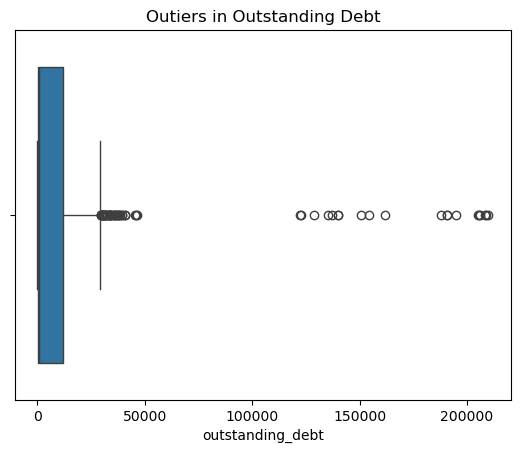

In [363]:
sns.boxplot(x=df_cred_prof["outstanding_debt"])
plt.title("Outiers in Outstanding Debt")
plt.show()

#Checking the outsanding debt above than their respective credit_limit
df_cred_prof[df_cred_prof["outstanding_debt"]>df_cred_prof["credit_limit"]]

In [364]:
#Handling those using .loc function -> The outsatnding debt cannot be more than credit_limit. So assigning the same
df_cred_prof.loc[df_cred_prof["outstanding_debt"]>df_cred_prof["credit_limit"],"outstanding_debt"] = df_cred_prof["credit_limit"]

In [365]:
df_cred_prof.loc[df_cred_prof["outstanding_debt"]>df_cred_prof["credit_limit"]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range,credit_limit_mode


##### So for now the outliers have been handled. Now let's check into correlation between different variables, taking 2 variables - <span style="color: red;">**Bivariate Analysis** </span>

In [366]:
df_cred_prof.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [367]:
df_merged = df_customers.merge(df_cred_prof, on="cust_id", how = "inner")
df_merged.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,cred_score_range,credit_limit_mode
0,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married,18-25,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married,18-25,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married,26-48,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [368]:
corr_matrix =df_merged[["age","annual_income","credit_score","credit_utilisation","outstanding_debt","credit_limit"]].corr()
corr_matrix

,age,annual_income,credit_score,credit_utilisation,outstanding_debt,credit_limit
age,1.000000,0.620225,0.447320,-0.029994,0.444517,0.512155
annual_income,0.620225,1.000000,0.575733,-0.086191,0.554922,0.684507
credit_score,0.447320,0.575733,1.000000,-0.068281,0.680852,0.848261
credit_utilisation,-0.029994,-0.086191,-0.068281,1.000000,0.193771,-0.079631
outstanding_debt,0.444517,0.554922,0.680852,0.193771,1.000000,0.810502
credit_limit,0.512155,0.684507,0.848261,-0.079631,0.810502,1.000000


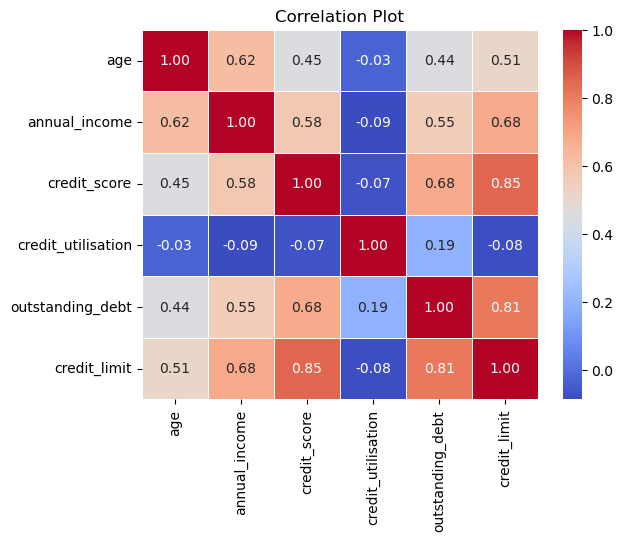

In [369]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f",cmap="coolwarm", linewidth=0.5)
plt.title("Correlation Plot")
plt.show()

##### From the above heatmap we can arrive some insights of how each numerical variables are correlated to each other.
1. <span style="color: red;"> **Credit Score - Credit Limit ==> 85%** </red>
2. <span style="color: green;"> **Annual Income - Credit Limit ==> 68** </green>
3. <span style="color: blue"> **Outstanding Debt - Credit Limit ==> 81** </blue>

## <span style="color: red;"> **Let's have some EDA on Transactions DF** </span>

In [370]:
df_transactions.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [371]:
df_transactions.shape

(500000, 7)

In [372]:
df_transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711634,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


In [373]:
df_transactions.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

#### <span style="color: green;"> **Handling Null values and Outliers for Age** </span>

In [374]:
df_transactions[df_transactions.platform.isnull()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,None,Electronics,Net Banking
418,419,383,2023-01-01,338,None,Electronics,Credit Card
607,608,421,2023-01-01,700,None,Electronics,Phonepe
844,845,945,2023-01-01,493,None,Sports,Credit Card
912,913,384,2023-01-01,85,None,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,None,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,None,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,None,Sports,Net Banking
499833,499834,616,2023-09-05,97,None,Fashion & Apparel,Credit Card


##### We can't use mean or median as platfor column is with non- numerical value. So better is going with mod()

In [375]:
df_transactions.platform.mode()[0]

'Amazon'

##### Straight away adding mode value might note be good. As a customer POV many customers have their own preference of platform for each product category. So let's have a visual representation on that using <span style="color: green;"> **countplot from sns**</sapn>.

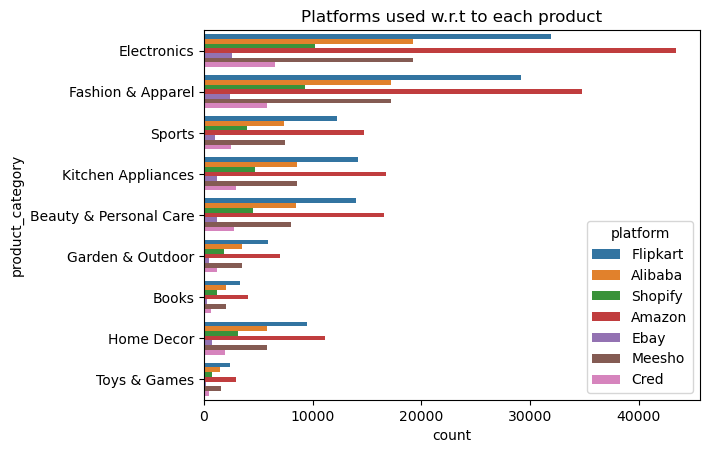

In [376]:
sns.countplot(data=df_transactions, y="product_category", hue="platform")
plt.title("Platforms used w.r.t to each product")
plt.show()

##### From the above plot it's understandable that in all the categories, Amazon platform leads. So let's straight away handle with mode.

In [377]:
df_transactions["platform"] = df_transactions["platform"].fillna(df_transactions["platform"].mode()[0])

In [378]:
df_transactions.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

##### So with this we are able to replace null values. Now from describe() we are able to find 0.00 as minimum value and 69,999 as maximum value giving a doubt for outliers. Let's handle them. Let's first plot it using histplot()

In [379]:
#Let's handle 0.00 transaction value first
df_transactions[df_transactions["tran_amount"]==0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499326,499327,695,2023-09-05,0,Amazon,Electronics,Credit Card
499494,499495,295,2023-09-05,0,Amazon,Electronics,Credit Card
499708,499709,141,2023-09-05,0,Amazon,Electronics,Credit Card
499928,499929,4,2023-09-05,0,Amazon,Electronics,Credit Card


##### There are 4734 rows repectively. From the above table we could find the retrived rows have platform , product_category and payment_method columns same. Let's confirm it once.

In [380]:
df_transactions[df_transactions["tran_amount"]==0].groupby(["platform","product_category","payment_type"])["tran_amount"].value_counts()

platform  product_category  payment_type  tran_amount
Amazon    Electronics       Credit Card   0              4734
Name: count, dtype: int64

##### Now from this above grouped data we could find those 3 columns grouped tran_amount is 0.0. So let's handle it by median with values above 0 caz there might be outlier and mean may not be fine in this case.

In [381]:
replace_med_value= df_transactions[(df_transactions["tran_amount"]>0) & (df_transactions["platform"]=="Amazon") & (df_transactions["product_category"]=="Electronics") & (df_transactions["payment_type"]=="Credit Card")]["tran_amount"].median()
replace_med_value

554.0

In [382]:
df_transactions.loc[df_transactions["tran_amount"] == 0, "tran_amount"] = replace_med_value

In [383]:
df_transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711634,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


In [384]:
df_transactions[df_transactions["tran_amount"]==0].groupby(["platform","product_category","payment_type"])["tran_amount"].value_counts()

Series([], Name: count, dtype: int64)

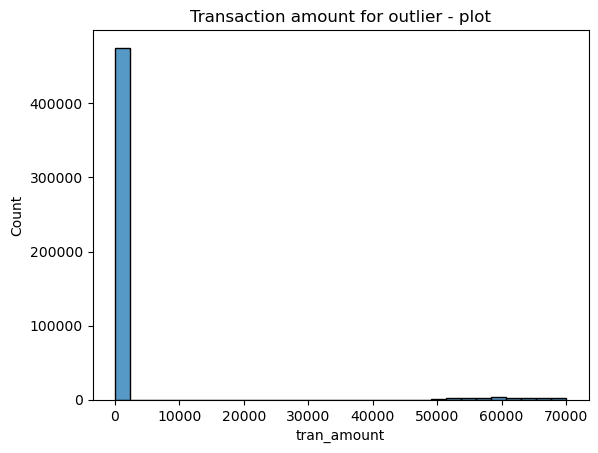

In [385]:
sns.histplot(df_transactions["tran_amount"], bins=30)
plt.title("Transaction amount for outlier - plot")
plt.show()

##### We could understan that the distribution is right skwed and so IQR is better to find out outlier rather than 3*STD which is basically used for Normal Distribution

In [386]:
#To find IQR will use quantile functions 
Q1,Q3 = df_transactions["tran_amount"].quantile([.25,.75])

IQR = Q3 - Q1

lower = Q1 - 2*IQR
upper = Q3 + 2*IQR

lower, upper

(-628.0, 1107.0)

##### Generally will go with 1.5*IQR here used 2 considering that some products_category have possibility of having a bit high trans amount. Lower value is need not to be considered as it's negative

In [387]:
df_transactions[df_transactions["tran_amount"]>=upper]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [388]:
#There are 25k rows with outlier - Let's group non-outliers w.r.t product category
mean_tran_amounts = df_transactions[df_transactions["tran_amount"]<upper].groupby("product_category")["tran_amount"].mean()
mean_tran_amounts

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [389]:
#Replacing the outlier values with mean of the non-outlier catefgory tran_amount 
for category, mean_value in mean_tran_amounts.items():
        # Update `tran_amount` for each category where `tran_amount` >= upper
    df_transactions.loc[
        (df_transactions["tran_amount"] >= upper) & (df_transactions["product_category"] == category),
        "tran_amount"
    ] = int(mean_value)

df_transactions[df_transactions["tran_amount"]>=upper]

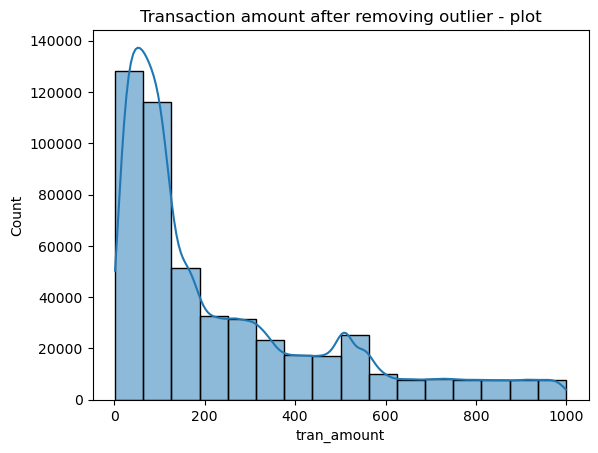

In [390]:
sns.histplot(df_transactions["tran_amount"],kde=True, bins=16)
plt.title("Transaction amount after removing outlier - plot")
plt.show()

#### So from the above we have removed Null values, Zeros and Outliers from Transaction table.
<span style="color: green;"> **Now let's have some visualization on the table**</sapn>.

In [391]:
df_transactions.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


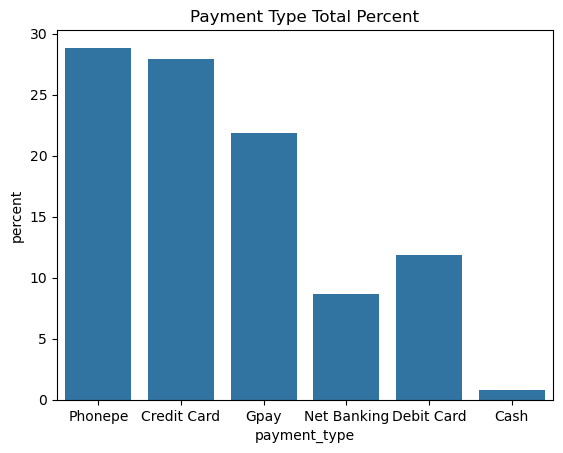

In [392]:
sns.countplot(data=df_transactions, x='payment_type', stat = 'percent')
plt.title("Payment Type Total Percent")
plt.show()

In [393]:
#Merging all 3 tables data to give an overall visualization
df_merged2 = df_merged.merge(df_transactions, on="cust_id", how="inner")
df_merged2.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,credit_inquiries_last_6_months,credit_limit,cred_score_range,credit_limit_mode,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1283,2023-01-01,30,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1382,2023-01-01,96,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1521,2023-01-01,86,Meesho,Garden & Outdoor,Gpay
3,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1576,2023-01-01,149,Amazon,Beauty & Personal Care,Phonepe
4,1,Manya Acharya,Female,55,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1757,2023-01-01,37,Flipkart,Fashion & Apparel,Credit Card


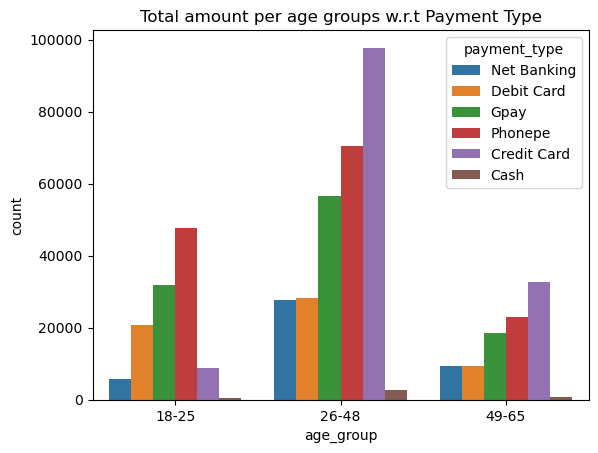

In [394]:
sns.countplot(data=df_merged2, x="age_group", hue="payment_type")
plt.title("Total amount per age groups w.r.t Payment Type")
plt.show()

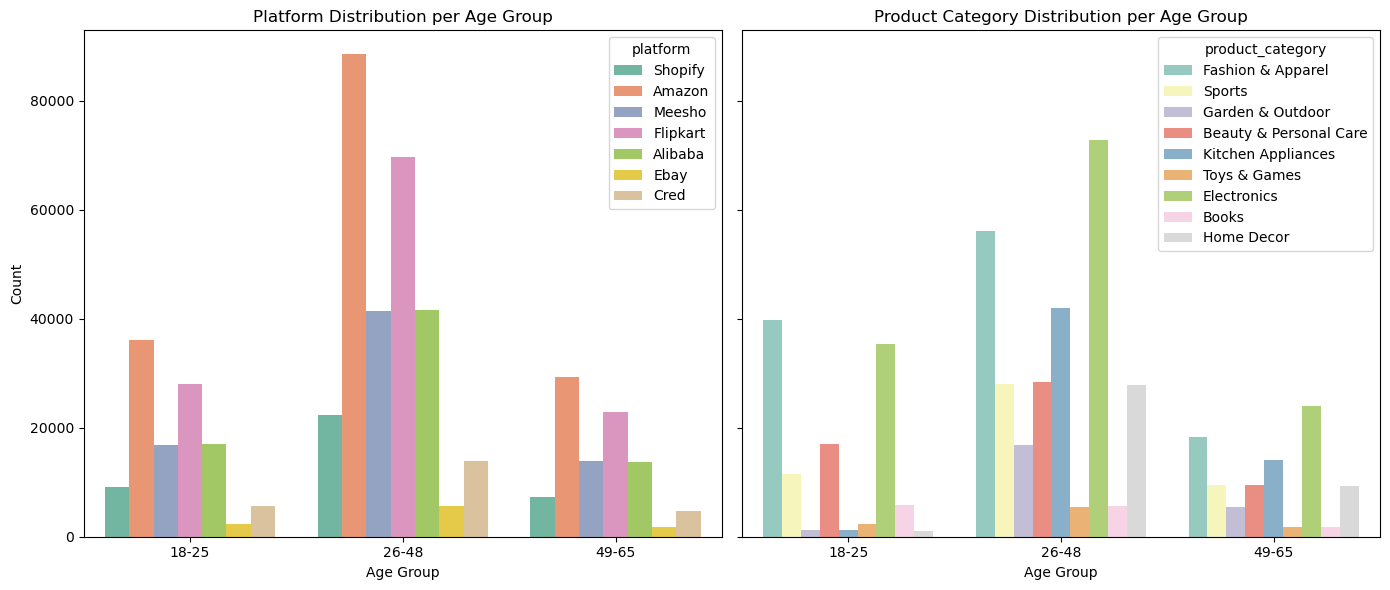

In [395]:
fig, (axes1,axes2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Platform Distribution per Age Group
sns.countplot(data=df_merged2, x="age_group", hue="platform", palette="Set2", ax=axes1)
axes1.set_title("Platform Distribution per Age Group")
axes1.set_xlabel("Age Group")
axes1.set_ylabel("Count")

# Plot 2: Product Category Distribution per Age Group
sns.countplot(data=df_merged2, x="age_group", hue="product_category", palette="Set3", ax=axes2)
axes2.set_title("Product Category Distribution per Age Group")
axes2.set_xlabel("Age Group")
axes2.set_ylabel("")

# Show the plots
plt.tight_layout()
plt.show()

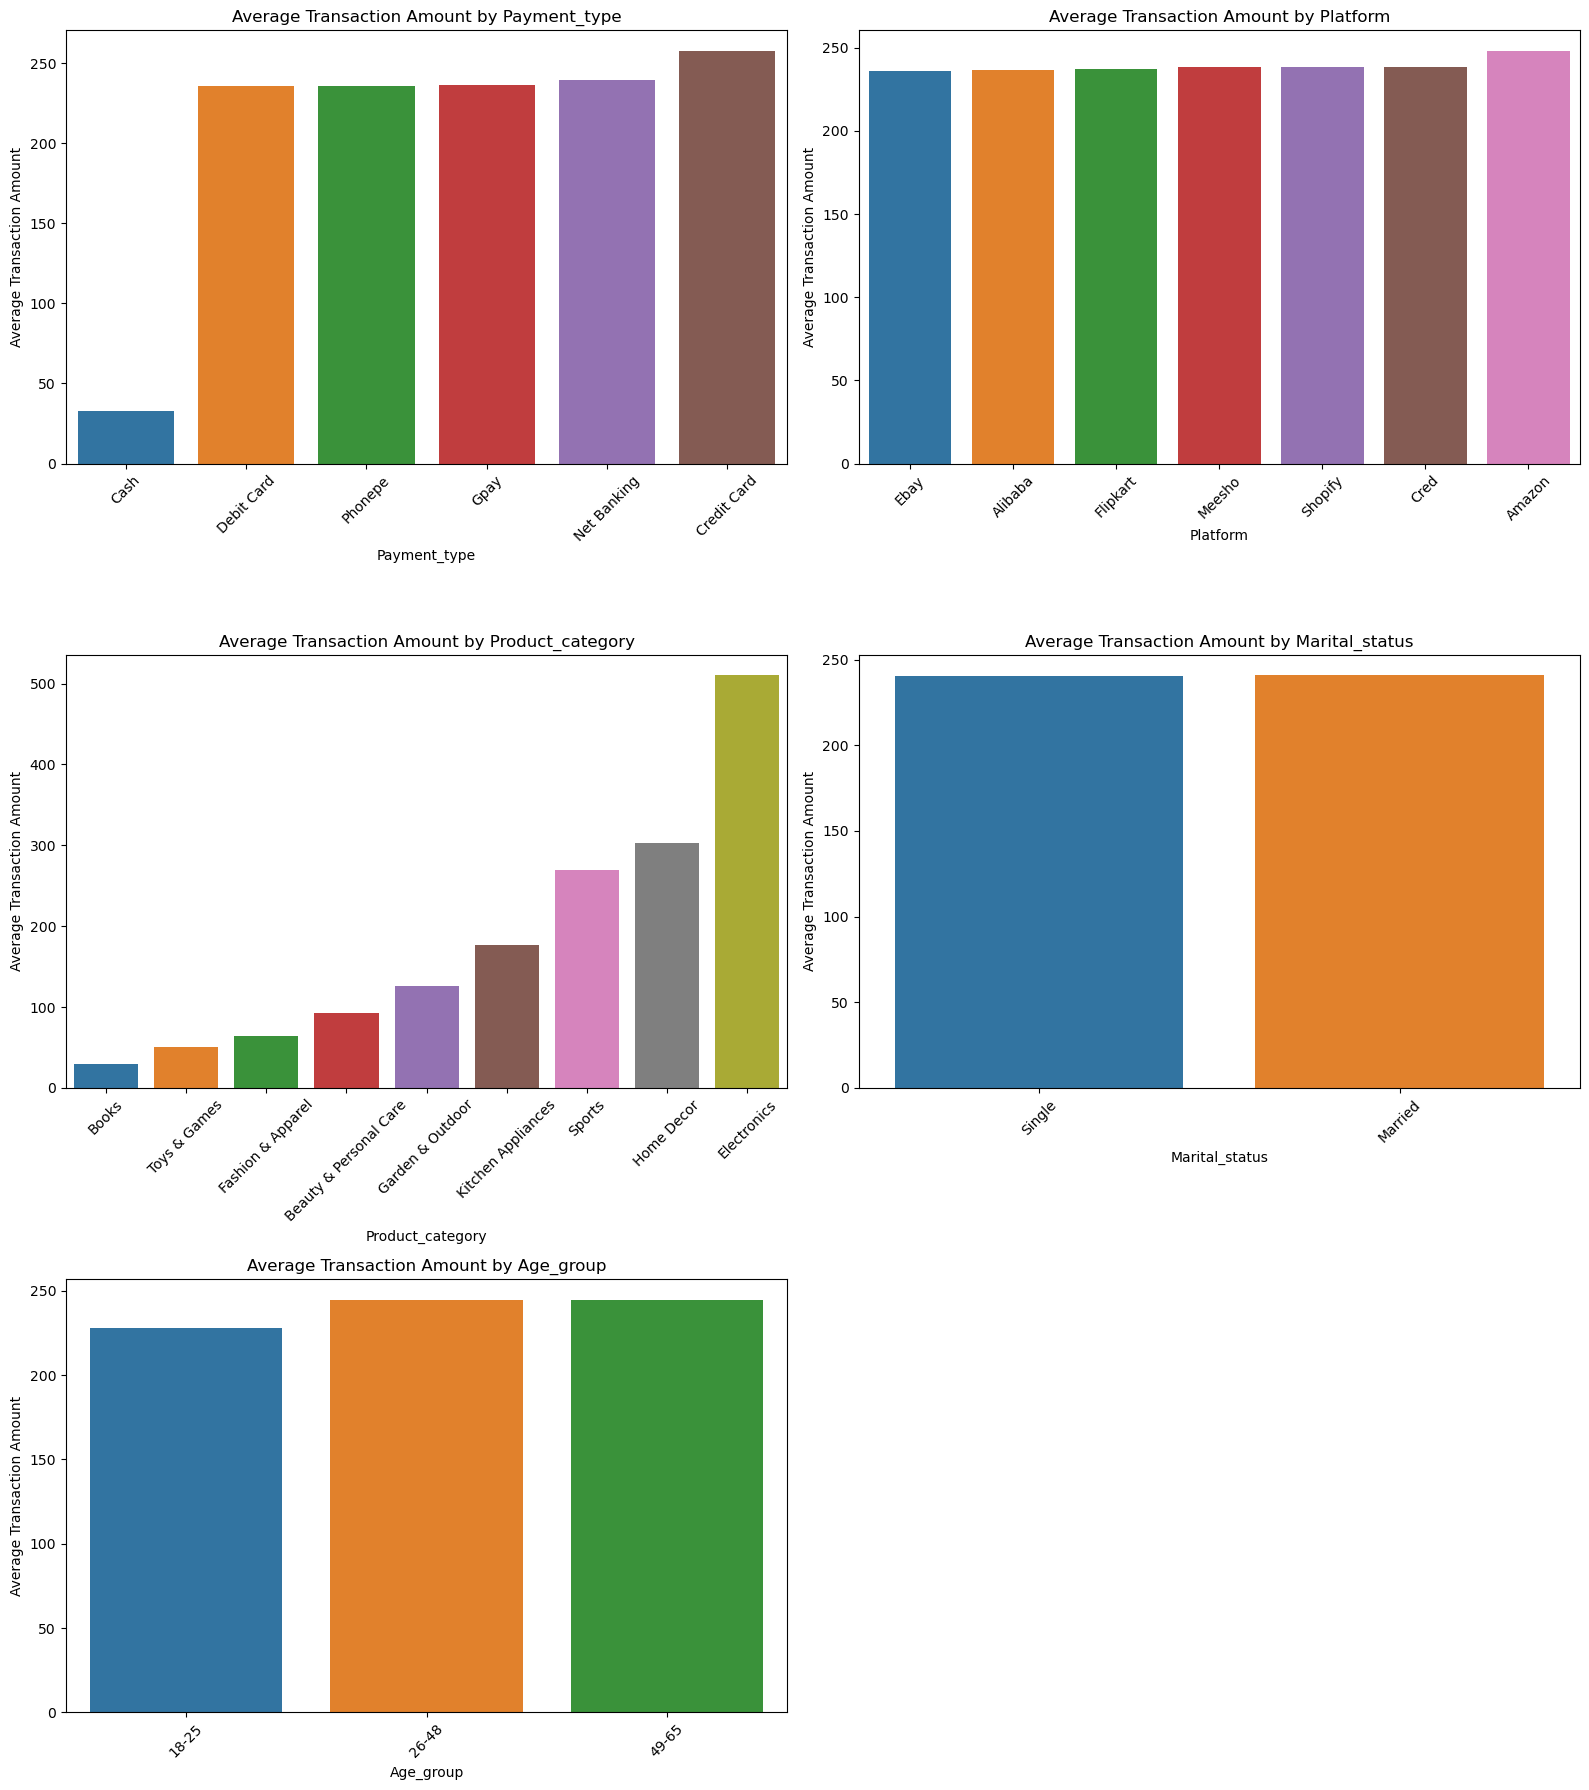

In [396]:

# List of categorical columns to plot
cat_cols = ["payment_type", "platform", "product_category", "marital_status", "age_group"]

# Set up the matplotlib figure with a 2x2 grid and one additional row
fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns layout for 5 plots
axes = axes.flatten()  # Flatten to easily index the axes

# Loop over each categorical column and create a bar plot
for i, col in enumerate(cat_cols):
    # Calculate mean tran_amount per category with observed=True to handle future behavior
    mean_values = df_merged2.groupby(col, observed=True)["tran_amount"].mean().sort_values()
    
    # Plot the bar plot on the respective axis
    sns.barplot(x=mean_values.index, y=mean_values.values,hue=mean_values.index, ax=axes[i], palette="tab10")
    axes[i].set_title(f"Average Transaction Amount by {col.capitalize()}")
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Average Transaction Amount")
    axes[i].tick_params(axis='x', rotation=45)

# Hide the last (6th) subplot if there are only 5 plots
axes[-1].set_visible(False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

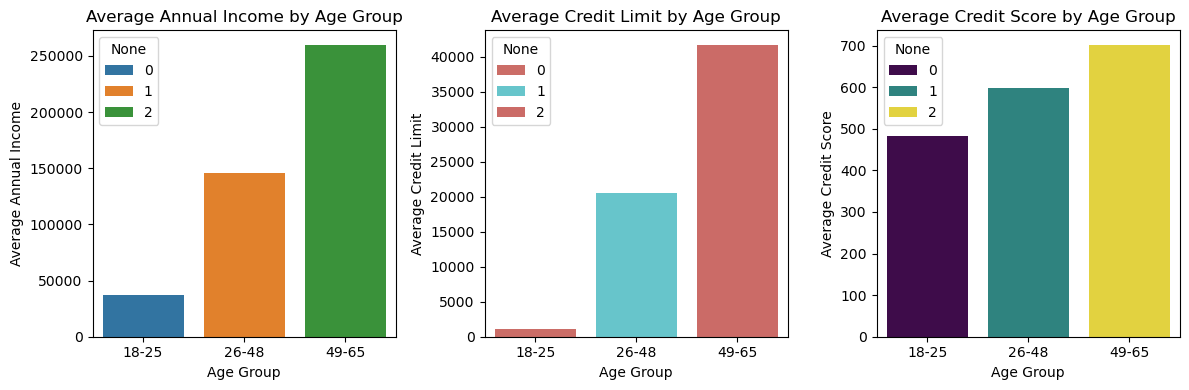

In [397]:
age_group_metrics = df_merged.groupby('age_group', observed=True)[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, hue=age_group_metrics.index, palette='tab10', ax=ax1)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Annual Income')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average Max Credit Limit by Age Group
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, hue=age_group_metrics.index, palette='hls', ax=ax2)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Average Credit Limit')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average Credit Score by Age Group
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, hue=age_group_metrics.index, palette='viridis', ax=ax3)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Average Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

<span style="color: green;">Finalize Target Market For a Trial Credit Card Launch</span>


#### Targeting Untapped market
1. People with age group of 18 -25 accounts to ~26% of customer base in the data
2. Avg annual income of this group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Top 3 most shopping products categories : Electronics, Fashion & Apparel, Beauty & Personal care

**1. Campaign Planning (Test & Control Group , Campaingn Time Period)**

**2. Execute Campaign - (Launch Campaign for Specific Customers)**

**3. Post Campaign Data Collection - (Collect Transactions from test and control customers)**

**4. Hypothesis Testing and Decision - (Determine if the transaction amount is different)**


We want to do trial run new credit card. First of all need to figure out how many customers do we need A/B testing. We will form control and test group. For both the groups we can figure out the number of customers we need based on the statistical power and effect size that wee agree while discussing with business.

In [403]:
alpha = .05 # 5% significance
power = .8 #High power size between 0-1, closer to 1 more the power
effect_size = .2

sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = alpha,
    power = power,
    ratio = 1,
    alternative = 'two-sided'
) #to find size of test and control group based on given params

393.4056989990348

There are possiblity that business may ask to reduce the size due to budgetting issues. So let's find this sample size for different effect sizes.

In [412]:
#calculating the required sample size for different effect sizes.
effect_sizes = [.1, .2, .3, .4, .5]

for effect_size in effect_sizes:
    sample_sz = sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = alpha,
    power = power,
    ratio = 1,
    alternative = 'two-sided')
    print(f"Effect size {effect_size} need sample size of {sample_sz:.0f}\n")

Effect size 0.1 need sample size of 1571

Effect size 0.2 need sample size of 393

Effect size 0.3 need sample size of 175

Effect size 0.4 need sample size of 99

Effect size 0.5 need sample size of 64



May be based on budget, 100 customers are possible for the campaign which can have an effect size of 0.4.

**Forming Control and Test Groups**

1. Identified approximately 246 customers withinn age group 18c-25. From this, will select 100 customers to launch initial campaign.
2. The campaign would run with the effect size for period of 2 months.
3. Got a conversion rate of ~40% (i.e 40 of 100 cusotmers in test group started using credit card)
4. To maintain similar sample size, a control group of 40 customers who is completely exclusive of intial 100 customers from test group is taken.
5. So there are 40 customers in each groups

**_After end of 2 month campaign period(from 09/10/23 to 11/10/23) a daily data showing average transaction amounts made by entire group of 40 customers in both the control and test groups using existing and newly lauch credit cards are taken into account. This data is already stored avg_transactions_after_campaign tbable for this analysis_**

Let's keep Null Hypothesis H0 and Alternative Hypothesis H1.
1. **H0- There won't be increase in avarage transactions between test and control group.**
2. **H0- There will be increase in avarage transactions for test compared to control group.**

In [444]:
conn = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database = "e_master_card"
)

In [417]:
df_avg_trans_aft_camp = pd.read_sql("select * from avg_transactions_after_campaign",conn)
df_avg_trans_aft_camp.head()

/var/folders/md/3r5147mj0951vm3v86b8vymmjmg0m4/T/ipykernel_3266/3567708835.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_avg_trans_aft_camp = pd.read_sql("select * from avg_transactions_after_campaign",conn)


,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,251.02,401.78
1,2023-09-11,250.77,326.16
2,2023-09-12,248.81,303.92
3,2023-09-13,255.90,363.29
4,2023-09-14,255.86,317.06


In [418]:
conn.close()

In [427]:
sam_size = df_avg_trans_aft_camp.shape[0]
sam_size

62

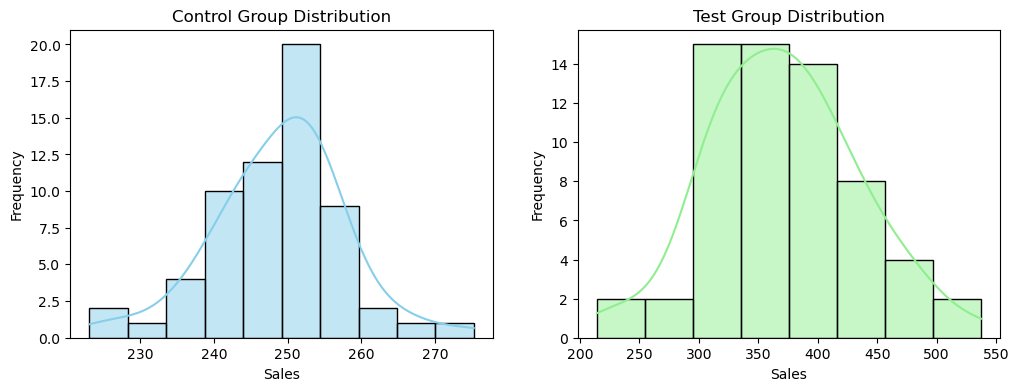

In [421]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.histplot(df_avg_trans_aft_camp["control_group_avg_tran"], kde= True, color="skyblue", label="Control Group Average Transactions", ax=ax1)
ax1.set_title('Control Group Distribution')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.legend

# Plot 2: Average Max Credit Limit by Age Group
sns.histplot(df_avg_trans_aft_camp["test_group_avg_tran"], kde= True, color="lightgreen", label="Test Group Average Transactions", ax=ax2)
ax2.set_title('Test Group Distribution')
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.legend

plt.show()

As sample size is more than **30** we will go with **Two sample z-test**. So let's find the mean and STD for both control and test.

In [423]:
control_mean = round(df_avg_trans_aft_camp["control_group_avg_tran"].mean(),2)
control_std = round(df_avg_trans_aft_camp["control_group_avg_tran"].std(),2)
test_mean = round(df_avg_trans_aft_camp["test_group_avg_tran"].mean(),2)
test_std = round(df_avg_trans_aft_camp["test_group_avg_tran"].std(),2)

print(f"Mean & STD for control group is {control_mean} and {control_std} respectively")
print(f"Mean & STD for test group is {test_mean} and {test_std} respectively")

Mean & STD for control group is 248.94 and 9.14 respectively
Mean & STD for test group is 370.54 and 63.25 respectively


In [429]:
#z_score = (test_mean - control_mean)/sqrt(sqr(test_std)/sam_size - sqr(control_std)/sam_size)
a = (test_std**2)/sam_size
b = (control_mean**2)/sam_size
z_score =  (test_mean - control_mean)/np.sqrt(a+b)
z_score

3.72778303668573

In [433]:
crit_value = st.norm.ppf(1 - alpha)
crit_value

1.644853626951472

In [434]:
z_score > crit_value

True

In [435]:
p_value = 1- st.norm.cdf(z_score)
p_value

9.658578182059063e-05

In [436]:
p_value < alpha

True

<span style="color: red;">**Since z_score is greater than crit_value and p_vaue is less than significance value we can reject null hypothesis**</span>


**We can also test this just by sm.stats.ztest()**. To find confidennce Interval now.

In [446]:
test_group_CI = st.norm.interval(.95, loc=test_mean, scale = test_std/np.sqrt(sam_size))
test_group_CI

(354.7960835592616, 386.28391644073844)

<span style="color: green;">**A confidence level of 95% would be got for average transactions between 355 to 386**</span>